# NAD+/NADH and NADP+/NADPH

In [1]:
import projectpath

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from mosmo.knowledge import kb
from mosmo.knowledge.thermo import Thermodynamics
from mosmo.model import KbEntry, DbXref, Molecule, Reaction, ReactionNetwork
from mosmo.sim.convenience_kinetics import ConvenienceKinetics, Ligands, ReactionKinetics, PackedNetworkKinetics
from mosmo.sim.fba_gd import SteadyStateObjective


jax.config.update('jax_enable_x64', True)

KB = kb.configure_kb()
thermo = Thermodynamics(p_h=7.3, p_mg=1.5, ionic_strength=0.25, temperature=298.15)
RT = 8.314463e-3 * 298.15  # kJ / mol
FARADAY = 96.485332  # kC / mol

## Two transhydrogenase reactions

- One is PMF-coupled. This is consistently treated as including stoichiometry H+(out): -1, H+(in): +1. This is correct in terms of tracking molecules, but not necessarily the most useful way to represent it for kinetic modeling. We eventually want a clean framework for this, but for now treat it as identical stoichiometry (for kinetics anyway), but with an additional ΔG for the PMF-coupled case. The net result will be a different balance for the forward/back kcat.

In [3]:
nad = KB("nad.ox")
nadh = KB("nad.red")
nadp = KB("nadp.ox")
nadph = KB("nadp.red")

proton = KB("h+")
proton_p = Molecule(_id='h+.p', name="proton (periplasm)", shorthand="H+(p)", charge=+1)
electron = Molecule(_id='e-', name='electron', shorthand='e-', charge=-1, mass=0.000548579903, xrefs=(DbXref("CHEBI","10545"),))

nad_reduction = Reaction("nad_red", name="NAD reduction", stoichiometry={nad: -1, proton: -1, electron: -2, nadh: +1})
nadp_reduction = Reaction("nadp_red", name="NADP reduction", stoichiometry={nadp: -1, proton: -1, electron: -2, nadph: +1})

udha = Reaction(
    _id="UdhA", 
    name="Energy-independent transhydrogenase",
    stoichiometry={nadh: -1, nadp: -1, nad: +1, nadph: +1},
    catalyst="UdhA",
)
pntab = Reaction(
    _id="PntAB", 
    name="PMF-coupled transhydrogenase",
    stoichiometry={nadh: -1, nadp: -1, proton_p: -1, nad: +1, nadph: +1, proton: +1},
    catalyst="PntAB",
)
ignored=[proton, proton_p, electron, KB("h2o")]

# Key ref for kinetics of UdhA/Sth, at least: https://doi.org/10.1111/j.1574-6968.2011.02287.x
kinetics = {
    udha: ReactionKinetics(kcat_f=200, kcat_b=1, km={nad: 0.133, nadph: 0.068}, ki={nadph: 1.0}, ka={}),
    pntab: ReactionKinetics(kcat_f=1, kcat_b=1, km={}, ki={}, ka={}),
}
network = ReactionNetwork([udha, pntab])
equations = ConvenienceKinetics(network, kinetics, ignore=ignored)

print(pd.DataFrame(
    network.s_matrix,
    index=[mol.label for mol in network.reactants],
    columns=[rxn.label for rxn in network.reactions],
    dtype=int))
print()

concs = {
    nad: 2.55,
    nadh: 8.36e-02,
    nadp: 2.08e-03,
    nadph: 1.21e-01,
    proton: np.power(10, -7.3) * 1000,
    proton_p: np.power(10, -6.7) * 1000,
}

# ΔG = ΔG° + RT ln Q
print(f"{nad_reduction.formula} ΔG° = {thermo.reaction_delta_g(nad_reduction):.2f},  ΔG = {thermo.reaction_delta_g(nad_reduction, concs):.2f}")
print(f"{nadp_reduction.formula} ΔG° = {thermo.reaction_delta_g(nadp_reduction):.2f},  ΔG = {thermo.reaction_delta_g(nadp_reduction, concs):.2f}")
print(f"{udha.formula} ΔG° = {thermo.reaction_delta_g(udha):.2f},  ΔG = {thermo.reaction_delta_g(udha, concs):.2f}")

       UdhA  PntAB
NADH     -1     -1
NADP+    -1     -1
NAD+      1      1
NADPH     1      1
H+(p)     0     -1
H+        0      1

NAD+ + H+ + 2 e- <=> NADH ΔG° = 66.78,  ΔG = 82.85
NADP+ + H+ + 2 e- <=> NADPH ΔG° = 63.80,  ΔG = 98.40
NADH + NADP+ <=> NAD+ + NADPH ΔG° = -2.98,  ΔG = 15.56


In other words, this system is maintained far from equilibrium, presumably by the PMF-driven transhydrogenase. This also means the ΔG of the PMF must be sufficient to maintain this disequilbrium.

The other possibility is that it's dynamic -- NADPH is being (net) produced and NADH (net) consumed at a high enough rate to overcome the tendency of the system toward a more balanced distribution. That would likely be harder to regulate though.

## Working hypothesis: Δp shifts the kinetics of the PntAB transhydrogenase reaction

- For PntAB we have two half-reactions, NADH + NADP <=> NAD + NADPH and H+(p) <=> H+(c)
- Overall ΔG° is the ΔG° from above plus ΔG due to the proton-motive force.
- (Haldane) $ln(k_{cat}^{+}) - ln(k_{cat}^{-}) = -\frac{\Delta{G}^{\circ}_r}{RT} - \sum\limits_i{(n_i ln({K_M}_i))}$
  - i.e. ΔG° of the reaction affects the relative magnitude of $k_{cat}^{+}$ and $k_{cat}^{-}$
- Mechanistically, the magnitude of the PMF is unlikely to affect binding affinities for NAD(P)(H) species, but it _can_ affect the energetics of the pre-transition, transition, and post-transition enzyme-complex states, all of which affect the observed $k_{cat}^{+}$ and $k_{cat}^{-}$


In [4]:
d_psi = -150  # mV
ph_p = 6.7
dg_p_psi = d_psi / 1000 * FARADAY  # mV * V/mV * (kJ/kC)/V * kC/mol = kJ/mol
dg_p_ph = -np.log(10) * RT * (thermo.cc.p_h.m - ph_p)
dg_p = dg_p_psi + dg_p_ph
print(f"At Δψ = {d_psi} mV and ΔpH = {thermo.cc.p_h.m - ph_p:.2f}:")
print(f"ΔGp = FΔψ + RT ln(H+[p]/H+[c]) = {dg_p_psi:.3f} + {dg_p_ph:.3f} = {dg_p:.3f}")

At Δψ = -150 mV and ΔpH = 0.60:
ΔGp = FΔψ + RT ln(H+[p]/H+[c]) = -14.473 + -3.425 = -17.898


Conventionally the PMF literature uses Δp (expressed in mV) to quantify PMF, rather than ΔG. The relationship is

$\Delta{p} = -\frac{\Delta{G}}{F} = -\Delta{\psi} + ln(10)\frac{RT}{F} \Delta{pH} \approx -\Delta{\psi} + 59.1 \Delta{pH}$ (mV)

But since all we're doing is multiplying by a constant (-1/F for volts, -1000/F for millivolts), the values are proportional

$\Delta{p}$ (mV) $\approx -10.36 \Delta{G}$ (kJ/mol)

Everything else we do thermodynamically uses ΔG in kJ/mol, so we'll stick with that. But it's easy enough to convert to mV for presentation.

In [5]:
print(f"ΔGp = {dg_p:.1f} kJ/mol => Δp = {-dg_p / FARADAY * 1000:.1f} mV")

ΔGp = -17.9 kJ/mol => Δp = 185.5 mV


## Steady-state NADH/NAD(tot) and NADPH/NADP(tot) as a function of [PntAB] at constant [Udh]
- with Δp = 185.5 mV

In [6]:
# Manually adjusted kvs to get kcat_f =~ 200
dgr0 = thermo.reaction_delta_g(udha)
equations.adjust_kinetics(dgrs=np.array([dgr0, dgr0 + dg_p]), kvs=np.array([4.647, 1.]))
equations.kparms

PackedNetworkKinetics(kcats_f=DeviceArray([199.95254114, 183.23042286], dtype=float64), kcats_b=DeviceArray([5.43758410e+01, 4.03265789e-02], dtype=float64), kms_s=DeviceArray([[0.1, 0.1],
             [0.1, 0.1]], dtype=float64), kms_p=DeviceArray([[0.133, 0.068],
             [0.1  , 0.1  ]], dtype=float64), kas=DeviceArray([], dtype=float64), kis=DeviceArray([[1.],
             [1.]], dtype=float64))

In [7]:
objective = SteadyStateObjective(network, [nad, nadh, nadp, nadph])

def ss_residual(state, enzyme_concs):
    rates = equations.reaction_rates(state, enzyme_concs)
    dmdt = network.s_matrix @ rates
    # manually enforce lower bound by penalizing negative state
    return jnp.concatenate([objective.residual(rates, dmdt), jnp.minimum(0, state)])

# There is really only one variable, the net turnover of the reaction NADH + NADP <=> NAD + NADPH
state0 = network.reactants.pack(concs)
def adjusted_state(x):
    return state0 + (network.s_matrix @ jnp.append(x, 0))

fn = lambda x, enzyme_concs: ss_residual(adjusted_state(x), enzyme_concs)
fn_jit = jax.jit(fn)
fn_jac = jax.jit(jax.jacfwd(fn))

enzyme_range = np.linspace(0, .1, 101)
states = []
velocities = []
residuals = []
for pntab_conc in enzyme_range:
    enzyme_concs = network.reactions.pack({udha: 0.001, pntab: pntab_conc})
    ss = scipy.optimize.least_squares(
        fun=fn_jit,
        x0 = np.zeros(1),
        jac=fn_jac,
        args=(enzyme_concs,),
    )
    
    state = adjusted_state(ss.x)
    states.append(state)
    velocities.append(equations.reaction_rates(state, enzyme_concs))
    residuals.append(np.sum(np.square(ss.fun)))

states = np.array(states)
velocities = np.array(velocities)
residuals = np.array(residuals)

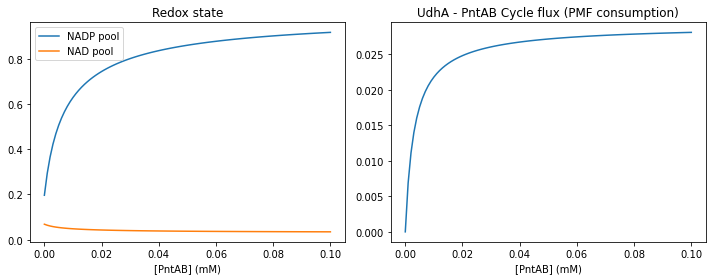

In [8]:
df = pd.DataFrame(states, index=enzyme_range, columns=[mol.label for mol in network.reactants])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(enzyme_range, df['NADPH']/(df['NADPH'] + df['NADP+']), label='NADP pool')
ax[0].plot(enzyme_range, df['NADH']/(df['NADH'] + df['NAD+']), label='NAD pool')
ax[0].set_xlabel('[PntAB] (mM)')
ax[0].set_title('Redox state')
ax[0].legend()
ax[1].plot(enzyme_range, velocities[:,1])
ax[1].set_xlabel('[PntAB] (mM)')
ax[1].set_title('UdhA - PntAB Cycle flux (PMF consumption)')
fig.tight_layout()
plt.show()

### Additional metrics
#### Total capacity, charge

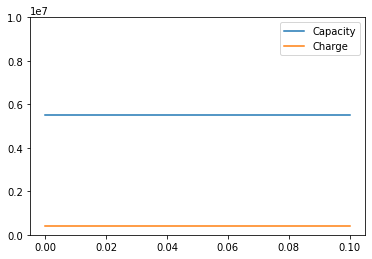

In [10]:
_nad = network.reactants.index_of(nad)
_nadh = network.reactants.index_of(nadh)
_nadp = network.reactants.index_of(nadp)
_nadph = network.reactants.index_of(nadph)

capacity_conc = np.sum(states[:, [_nad, _nadh, _nadp, _nadph]], axis=-1)
capacity_count = np.floor(capacity_conc * 2e6).astype(int)  # 1 mM ~ 2e6 electrons per cell

total_charge_conc = np.sum(states[:, [_nadh, _nadph]], axis=-1)
total_charge_count = np.floor(total_charge_conc * 2e6).astype(int)

plt.plot(enzyme_range, capacity_count, label="Capacity")
plt.plot(enzyme_range, total_charge_count, label="Charge")
plt.legend()
plt.ylim((0, 1e7))
plt.show()


#### Capacity, charge per pool

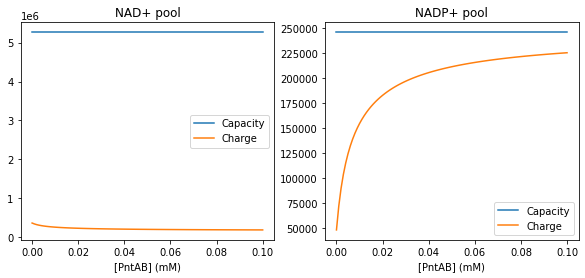

In [11]:
capacity_conc = np.sum(states[:, [[_nad, _nadh], [_nadp, _nadph]]], axis=-1)
capacity_count = np.floor(capacity_conc * 2e6).astype(int)  # 1 mM ~ 2e6 electrons per cell
charge_conc = states[:, [_nadh, _nadph]]
charge_count = np.floor(charge_conc * 2e6).astype(int)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
for _ax, cap, chg, pool in zip(ax, capacity_count.T, charge_count.T, ("NAD+", "NADP+")):
    _ax.plot(enzyme_range, cap, label="Capacity")
    _ax.plot(enzyme_range, chg, label="Charge")
    _ax.set_title(pool + " pool")
    _ax.set_xlabel('[PntAB] (mM)')
    _ax.legend()
plt.show()


#### Charge separation between pools

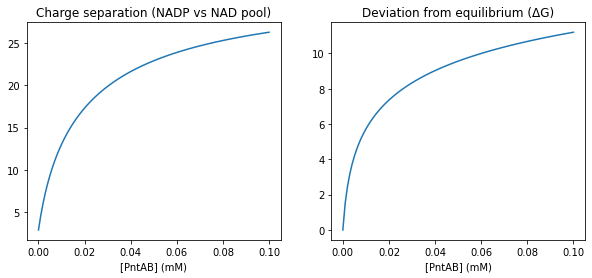

In [12]:
relative_charge = charge_conc / capacity_conc
separation = relative_charge[:, 1] / relative_charge[:, 0]

# ΔG = ΔG° + RT ln Q, for pool equalization
dgr0 = thermo.reaction_delta_g(udha)
ln_q = np.sum(np.log(states[:, [_nad, _nadh, _nadp, _nadph]]) * np.array([[1., -1, -1., 1]]), axis=1)
dgr = dgr0 + RT * ln_q

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(enzyme_range, separation)
ax[0].set_title("Charge separation (NADP vs NAD pool)")
ax[0].set_xlabel('[PntAB] (mM)')
ax[1].plot(enzyme_range, dgr)
ax[1].set_title("Deviation from equilibrium (ΔG)")
ax[1].set_xlabel('[PntAB] (mM)')
plt.show()

## Response to imbalanced e⁻ load

In [15]:
pd.Series(network.reactants.unpack(states[-1]))

[nad.red] NADH               0.091779
[nadp.ox] NADP+              0.010259
[nad.ox] NAD+                2.541821
[nadp.red] NADPH             0.112821
[h+.p] proton (periplasm)    0.000200
[h+] proton                  0.000050
dtype: float64

In [16]:
pd.Series(concs)

[nad.ox] NAD+                2.55000
[nad.red] NADH               0.08360
[nadp.ox] NADP+              0.00208
[nadp.red] NADPH             0.12100
[h+] proton                  0.00005
[h+.p] proton (periplasm)    0.00020
dtype: float64

In [17]:
pd.Series(velocities[-1], index=[rxn.label for rxn in network.reactions])

UdhA    -0.02807
PntAB    0.02807
dtype: float64

In [18]:
pd.Series(equations.reaction_rates(states[-1], np.array([0.001, 0.1])), index=[rxn.label for rxn in network.reactions])

UdhA    -0.02807
PntAB    0.02807
dtype: float64

In [21]:
net1 = ReactionNetwork([udha, pntab, nad_reduction, nadp_reduction])
print(pd.DataFrame(net1.s_matrix, index=[mol.label for mol in net1.reactants], columns=[rxn.label for rxn in net1.reactions], dtype=int))
print()

eq1 = ConvenienceKinetics(net1, kinetics, ignore=ignored)
eq1.adjust_kinetics(dgrs=np.array([dgr0, dgr0 + dg_p, 0, 0]), kvs=np.array([4.647, 1., 0., 0.]))
obj1 = SteadyStateObjective(net1, [nad, nadh, nadp, nadph, electron])

def adjusted_state(adjustment, state0):
    return state0 + net1.s_matrix[:, 0] * adjustment

def adjusted_rates(nadph_surplus, state, enzyme_concs):
    rates = eq1.reaction_rates(state, enzyme_concs)
    return rates + jnp.array([0., 0., 1., -1.]) * nadph_surplus

def ss_residual(rates):
    dmdt = net1.s_matrix @ rates
    return obj1.residual(rates, dmdt)

def fn(x, state0, enzyme_concs, nadph_surplus):
    # adjustment, nadph_surplus = x
    adjustment = x[0]
    state = adjusted_state(adjustment, state0)
    rates = adjusted_rates(nadph_surplus, state, enzyme_concs)
    residual = ss_residual(rates)
    return jnp.concatenate([residual, jnp.minimum(state, 0.)])

fn_jit = jax.jit(fn)
fn_jac = jax.jit(jax.jacfwd(fn))

state0 = np.append(states[-1], 0)
enzyme_concs=net1.reactions.pack({udha: 0.001, pntab: 0.1})

surplus_range = np.linspace(-.05, .05, 101)
states1 = []
velocities1 = []
residuals1 = []
for nadph_surplus in surplus_range:
    ss = scipy.optimize.least_squares(
        fun=fn_jit,
        x0 = np.zeros(1),
        jac=fn_jac,
        args=(state0, enzyme_concs, nadph_surplus),
    )
    
    state = adjusted_state(ss.x, state0)
    rate = adjusted_rates(nadph_surplus, state, enzyme_concs)
    states1.append(state)
    velocities1.append(rate)
    residuals1.append(np.sum(np.square(ss.fun)))

states1 = np.array(states1)
velocities1 = np.array(velocities1)
residuals1 = np.array(residuals1)

       UdhA  PntAB  nad_red  nadp_red
NADH     -1     -1        1         0
NADP+    -1     -1        0        -1
NAD+      1      1       -1         0
NADPH     1      1        0         1
H+(p)     0     -1        0         0
H+        0      1       -1        -1
e-        0      0       -2        -2



In [22]:
eq1.reaction_rates(np.append(states[-1], 0), enzyme_concs)

DeviceArray([-0.02807027,  0.02807027,  0.        ,  0.        ], dtype=float64)

In [23]:
ss_residual(adjusted_rates(0, np.append(states[-1], 0), enzyme_concs))

DeviceArray([ 5.55111512e-16, -5.55111512e-16, -5.55111512e-16,
              5.55111512e-16,  0.00000000e+00], dtype=float64)

In [24]:
fn_jit([0], np.append(states[-1], 0), enzyme_concs, 0)

DeviceArray([ 5.58580959e-16, -5.58580959e-16, -5.58580959e-16,
              5.58580959e-16,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00],            dtype=float64)

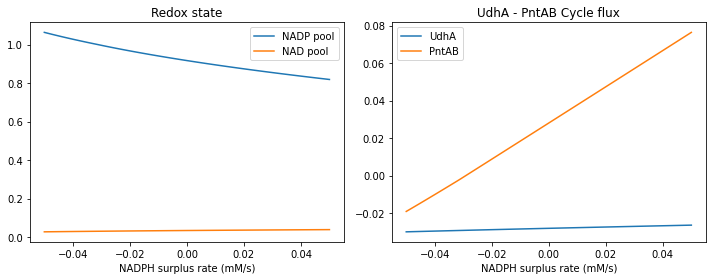

In [25]:
df = pd.DataFrame(states1, index=surplus_range, columns=[mol.label for mol in net1.reactants])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(surplus_range, df['NADPH']/(df['NADPH'] + df['NADP+']), label='NADP pool')
ax[0].plot(surplus_range, df['NADH']/(df['NADH'] + df['NAD+']), label='NAD pool')
ax[0].set_xlabel('NADPH surplus rate (mM/s)')
ax[0].set_title('Redox state')
ax[0].legend()
ax[1].plot(surplus_range, velocities1[:,0], label='UdhA')
ax[1].plot(surplus_range, velocities1[:,1], label='PntAB')
ax[1].set_xlabel('NADPH surplus rate (mM/s)')
ax[1].set_title('UdhA - PntAB Cycle flux')
ax[1].legend()
fig.tight_layout()
plt.show()

- Redox state > 1 clearly a bug
- Not that interesting really. But this all keeps total charge constant; the interesing responses will probably be when this can float based on
    - NADP surplus/deficit
    - ETC efficiency

## Timecourse response to e⁻ influx/removal
### via NADH, as a pulse

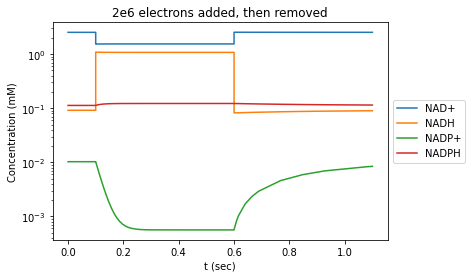

In [26]:
fn_jit = jax.jit(eq1.dstate_dt)
fn_jac = jax.jit(jax.jacfwd(eq1.dstate_dt))

pre = scipy.integrate.solve_ivp(
    fun=lambda t, state, enz: fn_jit(state, enz),
    jac=lambda t, state, enz: fn_jac(state, enz),
    y0=state0,
    args=(enzyme_concs,),
    t_span=(0., 0.1),
    method="BDF",
)

pulse = net1.s_matrix @ (1. * np.array([0, 0, 1, 0]))
sim1 = scipy.integrate.solve_ivp(
    fun=lambda t, state, enz: fn_jit(state, enz),
    jac=lambda t, state, enz: fn_jac(state, enz),
    y0=pre.y.T[-1] + pulse,
    args=(enzyme_concs,),
    t_span=(0.1, 0.6),
    method="BDF",
)

sim2 = scipy.integrate.solve_ivp(
    fun=lambda t, state, enz: fn_jit(state, enz),
    jac=lambda t, state, enz: fn_jac(state, enz),
    y0=sim1.y.T[-1] - pulse,
    args=(enzyme_concs,),
    t_span=(0.6, 1.1),
    method="BDF",
)

t = np.concatenate([pre.t, sim1.t, sim2.t])
y = np.concatenate([pre.y.T, sim1.y.T, sim2.y.T])
for mol in (nad, nadh, nadp, nadph):
    plt.plot(t, y[:, net1.reactants.index_of(mol)], label=mol.label)
plt.yscale('log')
plt.ylabel('Concentration (mM)')
plt.xlabel('t (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('2e6 electrons added, then removed')
plt.show()

I think that's a result: the absolute concentration of NADPH is maintained at a constant level, while NADH makes all the excess available to ETC
- Maybe not too surprising though -- the NADP pool is almost completely reduced, so it's not like NADPH can go up too much from there...

### via NADH, as a load over time

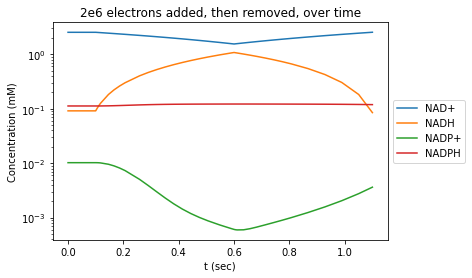

In [27]:
def dynamics(state, enzyme_concs, nad_red_rate):
    rates = eq1.reaction_rates(state, enzyme_concs)
    driver = nad_red_rate * jnp.array([0, 0, 1, 0])
    return net1.s_matrix @ (rates + driver)

fn_jit = jax.jit(dynamics)
fn_jac = jax.jit(jax.jacfwd(dynamics))

pre = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=state0,
    args=(enzyme_concs, 0.),
    t_span=(0., 0.1),
    method="BDF",
)

sim1 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=pre.y.T[-1],
    args=(enzyme_concs, +2.0), # +1 mM over 0.5 sec
    t_span=(0.1, 0.6),
    method="BDF",
)

sim2 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim1.y.T[-1],
    args=(enzyme_concs, -2.0), # -1 mM over 0.5 sec
    t_span=(0.6, 1.1),
    method="BDF",
)

t = np.concatenate([pre.t, sim1.t, sim2.t])
y = np.concatenate([pre.y.T, sim1.y.T, sim2.y.T])
for mol in (nad, nadh, nadp, nadph):
    plt.plot(t, y[:, net1.reactants.index_of(mol)], label=mol.label)
plt.yscale('log')
plt.ylabel('Concentration (mM)')
plt.xlabel('t (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('2e6 electrons added, then removed, over time')
plt.show()

### via NADPH, as a load over time

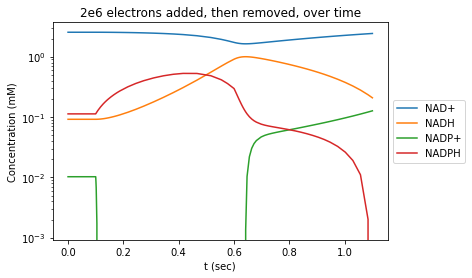

In [28]:
def dynamics(state, enzyme_concs, nadp_red_rate):
    rates = eq1.reaction_rates(state, enzyme_concs)
    driver = nadp_red_rate * jnp.array([0, 0, 0, 1])
    return net1.s_matrix @ (rates + driver)

fn_jit = jax.jit(dynamics)
fn_jac = jax.jit(jax.jacfwd(dynamics))

pre = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=state0,
    args=(enzyme_concs, 0.),
    t_span=(0., 0.1),
    method="BDF",
)

sim1 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=pre.y.T[-1],
    args=(enzyme_concs, +2), # +1 mM over 0.5 sec
    t_span=(0.1, 0.6),
    method="BDF",
)

sim2 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim1.y.T[-1],
    args=(enzyme_concs, -2), # -1 mM over 0.5 sec
    t_span=(0.6, 1.1),
    method="BDF",
)

t = np.concatenate([pre.t, sim1.t, sim2.t])
y = np.concatenate([pre.y.T, sim1.y.T, sim2.y.T])
for mol in (nad, nadh, nadp, nadph):
    plt.plot(t, y[:, net1.reactants.index_of(mol)], label=mol.label)
plt.yscale('log')
plt.ylabel('Concentration (mM)')
plt.xlabel('t (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('2e6 electrons added, then removed, over time')
plt.show()

**Unstable**: the system can't absorb (or release) the electrons as fast as they are flowing in (or out). Try a lower rate

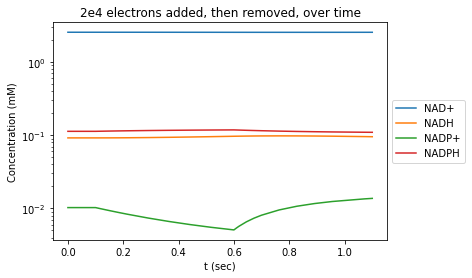

In [29]:

pre = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=state0,
    args=(enzyme_concs, 0.),
    t_span=(0., 0.1),
    method="BDF",
)

sim1 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=pre.y.T[-1],
    args=(enzyme_concs, +.02), # +1 mM over 0.5 sec
    t_span=(0.1, 0.6),
    method="BDF",
)

sim2 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim1.y.T[-1],
    args=(enzyme_concs, -.02), # -1 mM over 0.5 sec
    t_span=(0.6, 1.1),
    method="BDF",
)

t = np.concatenate([pre.t, sim1.t, sim2.t])
y = np.concatenate([pre.y.T, sim1.y.T, sim2.y.T])
for mol in (nad, nadh, nadp, nadph):
    plt.plot(t, y[:, net1.reactants.index_of(mol)], label=mol.label)
plt.yscale('log')
plt.ylabel('Concentration (mM)')
plt.xlabel('t (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('2e4 electrons added, then removed, over time')
plt.show()

Hypothesis: rate-limited by UdhA. If we then up-regulate UdhA / down-regulate PntAB...

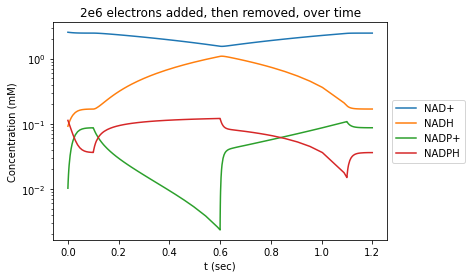

In [31]:
enzyme_concs1 = net1.reactions.pack({udha: 0.1, pntab: 0.1})

pre = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=state0,
    args=(enzyme_concs1, 0.),
    t_span=(0., 0.1),
    method="BDF",
)

sim1 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=pre.y.T[-1],
    args=(enzyme_concs1, +2), # +1 mM over 0.5 sec
    t_span=(0.1, 0.6),
    method="BDF",
)

sim2 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim1.y.T[-1],
    args=(enzyme_concs1, -2), # -1 mM over 0.5 sec
    t_span=(0.6, 1.1),
    method="BDF",
)

# Add a post-soak to let the system recover after removing the load
post = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim2.y.T[-1],
    args=(enzyme_concs1, 0.),
    t_span=(1.1, 1.2),
    method="BDF",
)

t = np.concatenate([pre.t, sim1.t, sim2.t, post.t])
y = np.concatenate([pre.y.T, sim1.y.T, sim2.y.T, post.y.T])
for mol in (nad, nadh, nadp, nadph):
    plt.plot(t, y[:, net1.reactants.index_of(mol)], label=mol.label)
plt.yscale('log')
plt.ylabel('Concentration (mM)')
plt.xlabel('t (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('2e6 electrons added, then removed, over time')
plt.show()

- Pre-soak finds a different steady-state, with less charge separation between NAD and NADP pools
- Way more stable with respect to higher net surplus/deficit rates of NADP reduction
- But none of the quantities is as constant as NADPH under the other regime
    - Though NADPH is maybe closer than the others. UdhA still not quite keeping up?

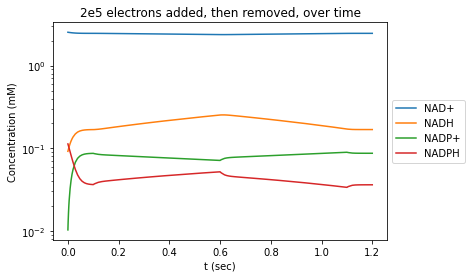

In [32]:
# 100x the previous activity of UdhA
enzyme_concs1 = net1.reactions.pack({udha: 0.1, pntab: 0.1})

pre = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=state0,
    args=(enzyme_concs1, 0.),
    t_span=(0., 0.1),
    method="BDF",
)

sim1 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=pre.y.T[-1],
    args=(enzyme_concs1, +.2), # +1 mM over 0.5 sec
    t_span=(0.1, 0.6),
    method="BDF",
)

sim2 = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim1.y.T[-1],
    args=(enzyme_concs1, -.2), # -1 mM over 0.5 sec
    t_span=(0.6, 1.1),
    method="BDF",
)

# Add a post-soak to let the system recover after removing the load
post = scipy.integrate.solve_ivp(
    fun=lambda t, *args: fn_jit(*args),
    jac=lambda t, *args: fn_jac(*args),
    y0=sim2.y.T[-1],
    args=(enzyme_concs1, 0.),
    t_span=(1.1, 1.2),
    method="BDF",
)

t = np.concatenate([pre.t, sim1.t, sim2.t, post.t])
y = np.concatenate([pre.y.T, sim1.y.T, sim2.y.T, post.y.T])
for mol in (nad, nadh, nadp, nadph):
    plt.plot(t, y[:, net1.reactants.index_of(mol)], label=mol.label)
plt.yscale('log')
plt.ylabel('Concentration (mM)')
plt.xlabel('t (sec)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('2e5 electrons added, then removed, over time')
plt.show()

## Parameter Fitting
### General Approach
- reaction_rates() and dstate_dt() have hooks to provide (packed) kinetic parameters at call time. We leverage this to include parameters as variables in our optimization/simulation/ensemble experiments
- at call time, we need fully specified state, enzyme_concs (technically part of state), and kinetics. For a given experiment we have a defined mapping from a 1d arg vector ('x') to these three objects. There are no theoretical restrictions here, and the mapping is completely up to the experiment
- analysis and scoring of the output is also up to the experiment. Plan on a composite objective incentivizing (i.e. penalizing deviation from)
    - intrinsic properties
        - steady state
        - _a priori_ concentration ranges
        - _a priori_ kinetic parameter expectations
    - observed quantities
        - measured state
        - reported kinetic parameters
        - measured production/flux
        - any kind of 'omics
    - these will probably resuse exiting Objective subsclasses, and extend new ones. It's also possible we'll have to broaden the framework
- inner call may be based on finding steady state, or solve_ivp for some defined interval (assuming that should get us to steady state). This may take some fiddling, since we want to balance inner-loop performance vs robustness and flexibility
- outer loop may be optimization, ensemble modeling, MCMC, etc

In [33]:
# Don't jump too soon to defining an Experiment object, just build it all ad-hoc

# Constant for the purpose of this experiment
state0 = network.reactants.pack(concs)
enzyme_concs = network.reactions.pack({udha: 0.01, pntab: 0.1})
kparms = equations.kparms
dgrs = jnp.array([thermo.reaction_delta_g(udha), thermo.reaction_delta_g(udha) + dg_p])
kvs = jnp.array([4.647, 1.])

# Factored out of ConvenienceKinetics -- rethink
def adjusted_kinetics(kinetics, dgrs, kvs):
    ln_km_s = jnp.log(kinetics.kms_s)
    ln_km_p = jnp.log(kinetics.kms_p)
    diffs = -dgrs / RT + jnp.sum(ln_km_s, axis=-1) - jnp.sum(ln_km_p, axis=-1)
    kcats = jnp.exp(kvs + jnp.array([[0.5], [-0.5]]) * diffs)
    return PackedNetworkKinetics(
        kcats_f=kcats[0],
        kcats_b=kcats[1],
        kms_s=kinetics.kms_s,
        kms_p=kinetics.kms_p,
        kas=kinetics.kas,
        kis=kinetics.kis,
    )

print(kparms.kcats_f, kparms.kcats_b)
_kparms = adjusted_kinetics(kparms, dgrs, kvs)
print(_kparms.kcats_f, _kparms.kcats_b)

[199.95254114 183.23042286] [5.43758410e+01 4.03265789e-02]
[199.95254114 183.23042286] [5.43758410e+01 4.03265789e-02]


#### $g(\vec{\Theta}) \rightarrow (f(\vec{\vec{y}}) \rightarrow d\vec{\vec{y}}/dt, \vec{\vec{v}})$
- i.e. given an ensemble $\vec{\Theta}$, produce a function (+jit/jac) suitable to optimize and/or simulate a _corresponding_ vector of state vectors
- the result is a mapping of $\Theta$ to steady-state $y$, and all that follows from it.
- much more straightforward than I've been thinking? could be just what I need
    - But wait, I was reading the docs wrong for solve_ivp(vectorized=True). It doesn't simultaneously simulate an array of state vectors, it just lets a solver multiplex calls to the dynamics function _at its discretion_. This makes sense, because the dynamics of $f(\vec{y})$ under each $\Theta$ could be very different, which undermines the optimizations in the solver itself. So it's an open question whether/how batching like I'm think of here improves things
    - Bottom line: make it work, and try it with different batch sizes. Both with optimization and brief simulation to find steady state.

#### First things first: ensemble PackedNetworkKinetics
- identical structure, but every array has up to 2 prefix dimensions (dgr and/or kv)

In [34]:
prng = jax.random.PRNGKey(0)
dgrs_e = dgrs + 0.1 * jax.random.normal(prng, (3,) + dgrs.shape)
kvs_e = jax.random.uniform(prng, shape=(5, network.shape[1])) * 5

# kvs.shape[-1] = diffs.shape[-1] = #rxns
print(dgrs_e.shape, kvs_e.shape)

(3, 2) (5, 2)


In [35]:
# ln_km arrays have shape (#rxns, width), and sum to shape (#rxns,)
ln_km_s = jnp.log(kparms.kms_s)
ln_km_p = jnp.log(kparms.kms_p)
print(ln_km_s.shape, ln_km_p.shape)

sum_ln_kms = jnp.sum(ln_km_s, axis=-1) - jnp.sum(ln_km_p, axis=-1)
print(sum_ln_kms.shape)

(2, 2) (2, 2)
(2,)


In [36]:
# diffs.shape = dgrs.shape
diffs = -dgrs / RT + sum_ln_kms
diffs_e = -dgrs_e / RT + sum_ln_kms
print(diffs.shape, diffs_e.shape)

(2,) (3, 2)


In [37]:
# kcats.shape = (2,) + kvs.shape[:-1] + diffs.shape
offsets = jnp.array([+0.5, -0.5]).reshape((2,) + (1,) * len(diffs.shape)) * diffs
print(offsets.shape)
offsets_e = jnp.array([+0.5, -0.5]).reshape((2,) + (1,) * len(diffs_e.shape)) * diffs_e
print(offsets_e.shape)

(2, 2)
(2, 3, 2)


Combining kvs_e and offsets_e is... complex.  Maybe just keep it simple and only one ensemble dimension at a time

In [38]:
offsets_e + kvs

DeviceArray([[[ 5.27407471,  5.23292497],
              [ 5.28913115,  5.1986735 ],
              [ 5.30598448,  5.19677452]],

             [[ 4.01992529, -3.23292497],
              [ 4.00486885, -3.1986735 ],
              [ 3.98801552, -3.19677452]]], dtype=float64)

In [39]:
offsets.reshape(2, 1, 2) + kvs_e

DeviceArray([[[ 4.9219633 ,  5.04174731],
              [ 2.03135429,  6.64715233],
              [ 5.61130059,  4.36154407],
              [ 1.73255195,  6.09510101],
              [ 3.80458223,  9.01796836]],

             [[ 3.61980322, -3.3797417 ],
              [ 0.7291942 , -1.77433668],
              [ 4.3091405 , -4.05994493],
              [ 0.43039187, -2.32638799],
              [ 2.50242214,  0.59647936]]], dtype=float64)

In [40]:
kcats_ee = jnp.exp(offsets_e.reshape(2, 1, 3, 2) + kvs_e.reshape(1, 5, 1, 2))
kcats_ee[0].shape

(5, 3, 2)

Ok, maybe it'll work. Not that that means it's necessarily a good idea to vary on both axes in the same ensemble. And maintaining code like this could get dicey. OTOH if it Just Works™ that might be cool.

In [41]:
def ensemble_kinetics(kparms, dgr, kv):
    # Keep track of the shapes of dgr and kv, which determine the shape of the final output.
    # - dgr.shape[-1] = kv.shape[-1] = #rxns
    # - ensemble kcats_f and _b have shape dgr_prefix + kv_prefix + (#rxns,)
    dgr_prefix = dgr.shape[:-1]
    kv_prefix = kv.shape[:-1]
    num_rxns = dgr.shape[-1]

    # ln_km arrays have shape (#rxns, width), and sum to shape (#rxns,)
    ln_km_s = np.log(kparms.kms_s)
    ln_km_p = np.log(kparms.kms_p)
    sum_ln_km = np.sum(ln_km_s, axis=-1) - np.sum(ln_km_p, axis=-1)
    
    # diff.shape = dgr.shape = dgr_prefix + (#rxns,); offsets multiply that by +/-0.5
    diff = -dgr / RT + sum_ln_km
    offsets = np.array([+0.5, -0.5]).reshape((2,) + (1,) * len(diff.shape)) * diff
    
    # Some careful reshaping to allow broadcasting kv vs offsets, into final shape (2,) + dgr_prefix + kv_prefix + (#rxns,)
    kcats = np.exp(kv + offsets.reshape((2,) + dgr_prefix + (1,) * len(kv_prefix) + (num_rxns,)))

    return PackedNetworkKinetics(
        kcats_f=kcats[0],
        kcats_b=kcats[1],
        kms_s=kparms.kms_s,
        kms_p=kparms.kms_p,
        kas=kparms.kas,
        kis=kparms.kis,
    )

def shapes(kparms):
    print(f"kcat: {kparms.kcats_f.shape}, {kparms.kcats_b.shape}")
    print(f"km  : {kparms.kms_s.shape}, {kparms.kms_p.shape}")
    print(f"reg : {kparms.kas.shape}, {kparms.kis.shape}")

shapes(kparms)

kcat: (2,), (2,)
km  : (2, 2), (2, 2)
reg : (2, 0), (2, 1)


In [42]:
shapes(ensemble_kinetics(kparms, dgrs, kvs))

kcat: (2,), (2,)
km  : (2, 2), (2, 2)
reg : (2, 0), (2, 1)


In [43]:
shapes(ensemble_kinetics(kparms, dgrs, kvs_e))

kcat: (5, 2), (5, 2)
km  : (2, 2), (2, 2)
reg : (2, 0), (2, 1)


In [44]:
shapes(ensemble_kinetics(kparms, dgrs_e, kvs))

kcat: (3, 2), (3, 2)
km  : (2, 2), (2, 2)
reg : (2, 0), (2, 1)


In [45]:
shapes(ensemble_kinetics(kparms, dgrs_e, kvs_e))

kcat: (3, 5, 2), (3, 5, 2)
km  : (2, 2), (2, 2)
reg : (2, 0), (2, 1)


#### Vectorize reaction_rates()

In [46]:
equations.reaction_rates(state0, enzyme_concs)

DeviceArray([-0.29007462,  0.003267  ], dtype=float64)

In [47]:
equations.reaction_rates(state0, enzyme_concs, kparms)

DeviceArray([-0.29007462,  0.003267  ], dtype=float64)

In [48]:
equations.reaction_rates(state0, enzyme_concs, ensemble_kinetics(kparms, dgrs_e, kvs_e))

DeviceArray([[[-0.20399894,  0.00289933],
              [-0.01133059,  0.01443832],
              [-0.40644641,  0.00146855],
              [-0.00840396,  0.00831311],
              [-0.06673528,  0.15457842]],

             [[-0.20093946,  0.00268324],
              [-0.01116065,  0.01336219],
              [-0.40035071,  0.0013591 ],
              [-0.00827792,  0.00769351],
              [-0.06573441,  0.14305725]],

             [[-0.19756884,  0.00267135],
              [-0.01097344,  0.01330299],
              [-0.39363511,  0.00135308],
              [-0.00813907,  0.00765943],
              [-0.06463176,  0.14242352]]], dtype=float64)

In [49]:
equations.reaction_rates(state0, enzyme_concs, ensemble_kinetics(kparms, jnp.broadcast_to(dgrs, (2,) + dgrs.shape), jnp.broadcast_to(kvs, (3,) + kvs.shape)))

DeviceArray([[[-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ]],

             [[-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ]]], dtype=float64)

That was easy, at least for ensemble params. Ensemble states will be a different story

In [50]:
states_e = state0 * jnp.exp(jax.random.normal(prng, (8, state0.shape[0])))
states_e.shape

(8, 6)

In [51]:
equations.reaction_rates(states_e, enzyme_concs, kparms)

DeviceArray([[-0.21348498, -0.00071236],
             [-0.31490242, -0.00169702],
             [-0.29256569,  0.00901386],
             [-0.21314325,  0.08502046],
             [-0.30232595,  0.00159294],
             [-0.19755323, -0.00307277],
             [-0.24353735,  0.00228656],
             [-0.30233126,  0.00415489]], dtype=float64)

In [52]:
tilde_s = equations.substrates.map_state(state, padding=1.) / kparms.kms_s
tilde_p = equations.products.map_state(state, padding=1.) / kparms.kms_p
numerator = kparms.kcats_f * jnp.prod(tilde_s, axis=-1) - kparms.kcats_b * jnp.prod(tilde_p, axis=-1)
print(tilde_s.shape, tilde_p.shape, numerator.shape)


(2, 2) (2, 2) (2,)


In [53]:
# jnp.append(state, padding)[self.indices] / constants
print(states_e.shape)
print(jnp.append(states_e, 1.0).shape)
print(jnp.append(states_e, 1.0)[equations.substrates.indices].shape)

(8, 6)
(49,)
(2, 2)


The current implementation uses jnp.append(), which flattens the input. So everything runs, it's just not the intent.

In [54]:
def select_state(state, indices, padding=1.):
    if len(state.shape) == 1:
        return jnp.append(state, padding)[indices]
    
    # Arbitrary array of state vectors -> vector of arbitrary arrays of state values. Append matching array of padding.
    _state = jnp.moveaxis(state, -1, 0)
    # print(state.shape, _state.shape)
    _state = jnp.vstack([_state, jnp.full((1,) + _state.shape[1:], padding)])
    # print(_state.shape)

    # Use the selector indices to get a 2d array of arbitrary arrays of state vules
    _values = _state[indices]
    # print(_values.shape)
    # Rearrange to anrbitrary array of 2d arrays
    _values = jnp.moveaxis(_values, (0, 1), (-2, -1))
    # print(_values.shape)
    return _values

print(select_state(state0, equations.substrates.indices).shape)
print(select_state(state0 * jnp.exp(jax.random.normal(prng, (3, 5, state0.shape[0]))), equations.substrates.indices).shape)
print(select_state(state0 * jnp.exp(jax.random.normal(prng, (8, state0.shape[0]))), equations.substrates.indices).shape)
print(select_state(state0 * jnp.exp(jax.random.normal(prng, (4, 3, 7, 2, state0.shape[0]))), equations.substrates.indices).shape)


(2, 2)
(3, 5, 2, 2)
(8, 2, 2)
(4, 3, 7, 2, 2, 2)


In [55]:
kparms_e = ensemble_kinetics(kparms, dgrs_e, kvs_e)
states_e = state0 * jnp.exp(jax.random.normal(prng, (dgrs_e.shape[0], kvs_e.shape[0], state0.shape[0])))

tilde_s = select_state(states_e, equations.substrates.indices) / kparms_e.kms_s
tilde_p = select_state(states_e, equations.products.indices) / kparms_e.kms_p
numerator = kparms_e.kcats_f * jnp.prod(tilde_s, axis=-1) - kparms_e.kcats_b * jnp.prod(tilde_p, axis=-1)
print(tilde_s.shape, tilde_p.shape, numerator.shape)


(3, 5, 2, 2) (3, 5, 2, 2) (3, 5, 2)


In [56]:
denominator = jnp.prod(tilde_s + equations.substrates.mask, axis=-1) + jnp.prod(tilde_p + equations.products.mask, axis=-1) - 1

tilde_a = select_state(states_e, equations.activators.indices) / kparms_e.kas
activation = jnp.prod(tilde_a / (tilde_a + equations.activators.mask), axis=-1)
tilde_i = select_state(states_e, equations.inhibitors.indices, padding=0.) / kparms_e.kis
inhibition = jnp.prod(1 / (tilde_i + 1), axis=-1)

rates = enzyme_concs * activation * inhibition * numerator / denominator
print(denominator.shape, tilde_a.shape, tilde_i.shape, rates.shape)
print(rates)

(3, 5, 2) (3, 5, 2, 0) (3, 5, 2, 1) (3, 5, 2)
[[[-2.13645142e-01  6.63939457e-03]
  [-1.13309665e-02  2.35151367e-03]
  [-4.47610335e-01 -8.19483345e-04]
  [-3.82381751e-03  1.23555443e-01]
  [-7.10722159e-02 -7.82910734e-02]]

 [[-1.86805854e-01  2.00631742e-02]
  [-6.64569958e-03  2.31492099e-01]
  [-4.02934418e-01 -9.24105602e-06]
  [-8.79104834e-03  2.55730258e-02]
  [-6.76754508e-02  3.85061892e+00]]

 [[-2.09761942e-01  5.42680917e-03]
  [-3.65914599e-03  1.36840684e+00]
  [-3.58934241e-01  6.13236029e-03]
  [-8.90145104e-03 -4.33934970e-03]
  [-2.91156603e-02  2.42130784e-01]]]


In [57]:
def reaction_rates(equations, state, enzyme_concs, kparms):
    tilde_s = select_state(state, equations.substrates.indices) / kparms.kms_s
    tilde_p = select_state(state, equations.products.indices) / kparms.kms_p
    numerator = kparms.kcats_f * jnp.prod(tilde_s, axis=-1) - kparms.kcats_b * jnp.prod(tilde_p, axis=-1)
    denominator = jnp.prod(tilde_s + equations.substrates.mask, axis=-1) + jnp.prod(tilde_p + equations.products.mask, axis=-1) - 1

    tilde_a = select_state(state, equations.activators.indices) / kparms.kas
    activation = jnp.prod(tilde_a / (tilde_a + equations.activators.mask), axis=-1)
    tilde_i = select_state(state, equations.inhibitors.indices, padding=0.) / kparms.kis
    inhibition = jnp.prod(1 / (tilde_i + 1), axis=-1)

    rates = enzyme_concs * activation * inhibition * numerator / denominator
    return rates

reaction_rates(equations, state0, enzyme_concs, kparms)

DeviceArray([-0.29007462,  0.003267  ], dtype=float64)

In [58]:
reaction_rates(equations, jnp.vstack([state0] * 3), enzyme_concs, kparms)

DeviceArray([[-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ]], dtype=float64)

In [59]:
reaction_rates(equations, state0, jnp.vstack([enzyme_concs] * 3), kparms)

DeviceArray([[-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ]], dtype=float64)

In [60]:
reaction_rates(equations, state0, enzyme_concs, ensemble_kinetics(kparms, jnp.vstack([dgrs] * 3), kvs))

DeviceArray([[-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ]], dtype=float64)

In [61]:
reaction_rates(equations, state0, enzyme_concs, ensemble_kinetics(kparms, dgrs, jnp.vstack([kvs] * 3)))

DeviceArray([[-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ]], dtype=float64)

In [62]:
reaction_rates(
    equations,
    jnp.broadcast_to(state0, (3, 2) + state0.shape),
    jnp.broadcast_to(enzyme_concs, (2,) + enzyme_concs.shape),
    ensemble_kinetics(
        kparms, 
        jnp.broadcast_to(dgrs, (3,) + dgrs.shape), 
        jnp.broadcast_to(kvs, (2,) + kvs.shape)
    ),
)

DeviceArray([[[-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ]],

             [[-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ]],

             [[-0.29007462,  0.003267  ],
              [-0.29007462,  0.003267  ]]], dtype=float64)

In [63]:
reaction_rates(
    equations, 
    state0, 
    enzyme_concs,
    PackedNetworkKinetics(
        kcats_f=kparms.kcats_f,
        kcats_b=kparms.kcats_b,
        kms_s=jnp.broadcast_to(kparms.kms_s, (5,) + kparms.kms_s.shape),
        kms_p=kparms.kms_p,
        kas=kparms.kas,
        kis=kparms.kis,
    ),
)

DeviceArray([[-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ]], dtype=float64)

In [64]:
reaction_rates(
    equations, 
    state0, 
    enzyme_concs,
    PackedNetworkKinetics(
        kcats_f=kparms.kcats_f,
        kcats_b=kparms.kcats_b,
        kms_s=kparms.kms_s,
        kms_p=kparms.kms_p,
        kas=jnp.broadcast_to(kparms.kas, (3,) + kparms.kas.shape),
        kis=kparms.kis,
    ),
)

DeviceArray([[-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ],
             [-0.29007462,  0.003267  ]], dtype=float64)

In [65]:
equations.dstate_dt(state0, enzyme_concs)

DeviceArray([ 0.28680761,  0.28680761, -0.28680761, -0.28680761,
             -0.003267  ,  0.003267  ], dtype=float64)

In [66]:
equations.dstate_dt(state0, enzyme_concs) - (
    reaction_rates(
        equations,
        jnp.broadcast_to(state0, (3, 2) + state0.shape),
        jnp.broadcast_to(enzyme_concs, (2,) + enzyme_concs.shape),
        ensemble_kinetics(
            kparms, 
            jnp.broadcast_to(dgrs, (3,) + dgrs.shape), 
            jnp.broadcast_to(kvs, (2,) + kvs.shape)
        ),
    ) @ network.s_matrix.T
)

DeviceArray([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  1.30104261e-18, -1.30104261e-18],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  1.30104261e-18, -1.30104261e-18]],

             [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  1.30104261e-18, -1.30104261e-18],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  1.30104261e-18, -1.30104261e-18]],

             [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  1.30104261e-18, -1.30104261e-18],
              [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  1.30104261e-18, -1.30104261e-18]]],            dtype=float64)